In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from Lab_modules.Modules_tools import return_fsts


In the previous chapter we explored ways to visualize the overlap of distributions. These we simulated by generating clouds of points directly, with predetermined size and shape (covariance along 3 axes). We then varyied the distances that separated them. At each variation, we captured their pdfs and compared their values at a fixed number of coordinates (our observations).

This exercise, while fun, is only really relevant if your original data consists of three dimensional coordinates. We might be used to see structure in our data, it is another thing to show that it could acquire the shapes that would allow for the visualizations we developped.

In this post we shall create our clouds of points from frequency vectors, each encasing the probabilities of binary occurences. These are our real populations. 

We will begin by generating these vectors in the same way we did in **1. Generating Haplotypes** (link below), by varying the parameters _a_ and _b_ of the theta distribution and sampling from there.

- [1. Generate haplotypes](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/1.%20Generating_haplotypes.ipynb)

In [2]:
from Lab_modules.Generate_freq_vectors import generate_vectors_Beta

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 150
n= 100
rangeA= [1,2.5]
rangeB = [.1,.6]
steps= 20
n_comp = 100
density= 50


vector_lib, background= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)


We will now reduce the dimensions of this data. However, in this case we don't expect to find structure. We created our vectors randomly within our ranges. This feature space will be used solely to retrieve new vectors through inverse transformation following operations that are not limited to 3 dimensions. Thus, we will try to keep as much of the information as possible for that transformation.

In [3]:
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(2000, 100)
(2000, 150)


In [4]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter(
        x = features[:,0],
        y = features[:,1],
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


By hovering above the points, we see that variation along the first axis is usually correlated with the _a_ and _b_ parameters of the beta distribution.

**[Note]** If you played around with these parameters you will have noticed the beta distribution becomes less skewed as they rise. Although this relation is not linear, it will generally translate into vectors with a larger number of higher frequencies.

Other considerations aside, we will chose a number of populations from among these - i have set this number to 3. To change it, add or remove from the list 'Pops' and modify the list 'Sizes' as well.

The next block of code will calculate global and pairwise Fsts among the populations chosen. Modify your choice until you are happy with these values, i don't really have a better way to inform this choice right now.


In [5]:
#### calculating Fsts between populations.
Pops= [395,390]
Sizes= [100,100]

### return_fsts() in Modules_tools.
Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1068


,pops,fst
0,"(395, 390)",0.106762


Finally, for capturing regions of overlap between our populations.

We will pick two populations from among our choices and we will make their distance vary in the feature space of frequency vectors. We will do this by once again resorting to the sinusoid of their distance.

At each variation, we will calculate the pairwise fsts among all our populations. we will also store the distances separating our vectors in feature space. We will plot these values against each other afterwards.

We will first need to slightly modify our **return_fsts** function. Fsts of loci with 0 variation will be set to 0. This will still produce a runtime warning as it first attemps to divide by 0. Stay calm.

In [6]:
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [7]:
Pops

[395, 390]

In [10]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
target= [0,1]


labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(-10,10,.05):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend([tuple([x + 1 for x in y]) for y in Pairwise.pops])
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
fig_data= [go.Scatter(
x= Distances_crawl,
y= Fsts_crawl,
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

We can see that distances in feature space aren't linearly correlated to among-population fsts. This is to be expected. However the relationship is globally positive, i'll take that as a win and procede.

In [12]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}


fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]


layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)


fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)


Globally, we learn that distances in feature space are indeed related to the amount of differentiation among our populations. 

Now we will will perform the same exercice, but at each step we will draw haplotypes from our vectors. We will then reduce the dimensionality of our haplotype data set, and estimate the kernel density of each population in that space.

The values of each KDE at the coordinates of our drawn observations (haplotypes) will be extracted.

In [40]:
from Lab_modules.StructE_tools import extract_profiles
from IPython.display import clear_output

labels= [0,1]

label_vector= np.repeat(np.array([x for x in labels]),Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}

Windows= recursively_default_dict()
Blocks_truth= recursively_default_dict()

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}
threshold= .005
P= 30
n_comps= 5

Fst_labels= []

Fst_crawl= []

Fst_windows= []

var_comp_store= []

for angle in np.arange(-10,10,.1):
    print(angle)
    
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    N_pops= len(Pops)
    
    labels= np.repeat(np.array([x + 1 for x in range(N_pops)]),Sizes)
    
    data= []

    for k in range(N_pops):

        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        m= Sizes[k]
        Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]

        data.extend(Haps)
    
    data= np.array(data)
    pca2 = PCA(n_components=n_comps, whiten=False,svd_solver='randomized').fit(data)

    data= pca2.transform(data)
    
    local_pcvar= list(pca2.explained_variance_ratio_)

    local_pcvar= [angle,*local_pcvar]

    var_comp_store.append(local_pcvar)
    
    profiles= extract_profiles(data,label_indicies)
    
    ##### FSTs
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([angle] * Pairwise.shape[0])

    ### store stuff.
    Blocks_truth[int(angle*1000)]= labels
    Windows[int(angle*1000)]= profiles
    
    clear_output()


var_comp_store= np.array(var_comp_store)
var_comp_store= pd.DataFrame(var_comp_store,columns=['set',*['PC' + str(x + 1) for x in range(n_comps)]])

Windows= {1:Windows}

To wrap up we will classify each observation according to the KDE values it received at every step.

We will allow for pure, intermediate and outlier classes.

We will plot these classifications in the form of an ideogram and resort to the same color sceme as in the previous post. 


**pure classes**:
- pop1: red
- pop2: yellow
- pop3: blue

**Intermediate classes**
- pop1-pop2: orange
- pop2-pop3: green
- pop1-pop3: purple
- po1-pop2-pop3: silver

Assignments at varying steps of X will be plotted as a global ideogram.

-  Comparison_threshold= 5
-  Outlier_threshold= 1e-4


Functions `Merge_class()` (classification of collection of analyses), `compress_Ideo()` (reduce classification data set) and `return_Ideogram()` (plot classification across collection, uses matplotlib) can be found in Ideogram_tools.py


In [41]:
## set classification parameters, colors and organise input.
from Lab_modules.Lab_ideogram_tools import Merge_class

Out= {y:{x:x + 99 for x in Windows[y].keys()} for y in Windows.keys()}
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 1
Outlier_threshold= 1e-4
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

In [42]:
# prepare final classification data set

chromosome_list = []

Ideo = []

chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)


In [43]:
#### begin by compressing assignments by individuals. Lightens the load of the following plot.
from Lab_modules.Lab_ideogram_tools_II import compress_ideo

import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)


adding ideograms...


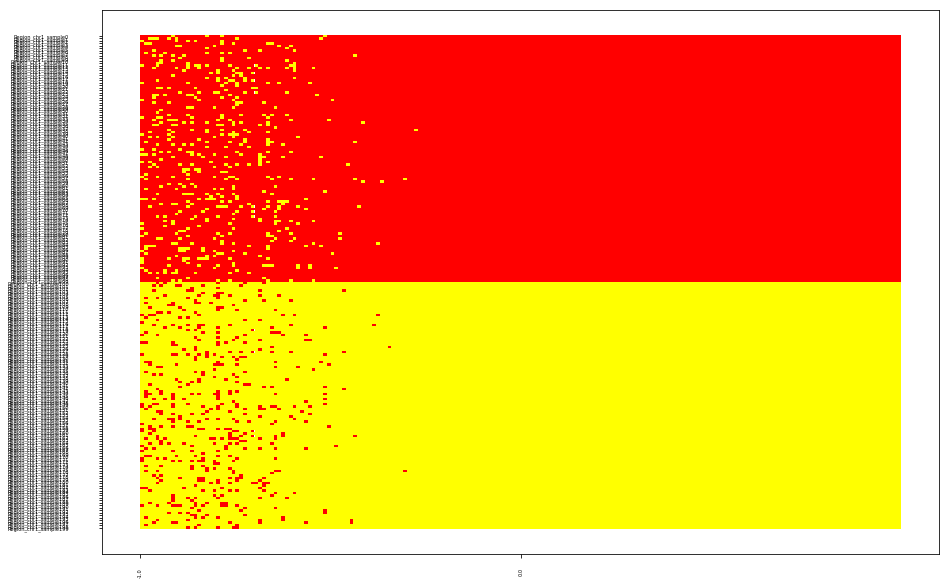

In [44]:
from Lab_modules.Lab_ideogram_tools_II import return_ideogram

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID,height= 10,width= 15)

In [45]:
wind= []
Proportions= []
labs= []
for w in Windows[1].keys():
    for combo in it.combinations(Windows[1][w].keys(),2):
        diffs= [abs(Windows[1][w][combo[0]][x] - Windows[1][w][combo[1]][x]) for x in range(len(Windows[1][w][combo[1]]))]
        
        Proportions.append(np.mean(diffs))
        labs.append(tuple([x+1 for x in combo]))
        wind.append(w)


In [57]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [59]:
coords= {z:[x for x in range(len(labs)) if labs[x] == z] for z in list(set(labs))}
Error_rate= []
where= []


for bl in Blocks[1].keys():
    non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != len(list(set(labels))) + 1]
    misshaps= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != Blocks_truth[1][bl][x] and Blocks[1][bl][x] in labels]
    rate= 1 - len(misshaps) / float(len(non_outlier))
    Error_rate.append(rate)
    where.append(bl)



fig_data= [go.Scatter(
y= [Error_rate[x] for x in coords[i]],
x= [Fst_crawl[x] for x in coords[i]],
mode= 'markers',
name= ' pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'average KDE score differences',
    yaxis=dict(
        title='Difference'),
    xaxis=dict(
        title='Fst')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

### Variance captured

In [50]:
var_comp_store.head()

,set,PC1,PC2,PC3,PC4,PC5
0,-10.0,0.036154,0.033015,0.030525,0.028707,0.028289
1,-9.9,0.032935,0.031961,0.029425,0.028831,0.027289
2,-9.8,0.032437,0.030307,0.029221,0.028447,0.027513
3,-9.7,0.035071,0.030899,0.029338,0.028608,0.028206
4,-9.6,0.031979,0.031817,0.030208,0.029261,0.027768


In [51]:
n_comp= var_comp_store.shape[1] - 1
PC_list= ['PC' + str(x + 1) for x in range(n_comp)]
total_var= var_comp_store[PC_list].sum(axis= 1)


X_plot = np.linspace(-0.1, 1, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(np.array(total_var).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'variance captured',
                            line=dict(color='blue', width=2))]
##


layout= go.Layout(
    title= 'ncomp: {}'.format(n_comp),
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'variance explained'
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)

In [ ]:
### Use *p*-value threshold to mask error

1
number of reference populations: 2
adding ideograms...


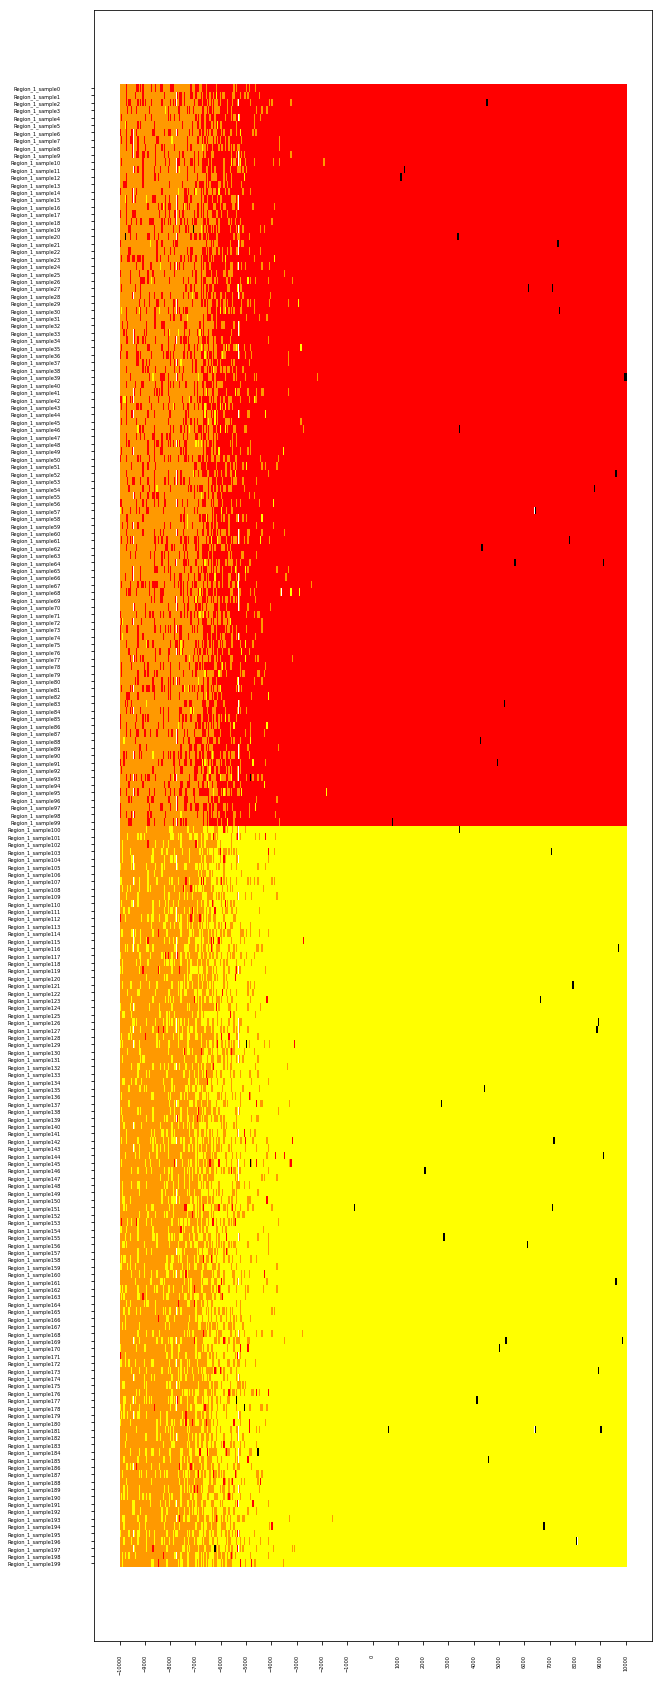

In [30]:
Comparison_threshold= 5
Outlier_threshold= 1e-4
color_ref= ['red','yellow','black','orange','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

chromosome_list = []

Ideo = []

chromosomes= Blocks2.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)

fig= return_ideogram(ideo)
